In [1]:
!pip install pylops


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from skimage import io
import pylops
import torch
from PIL import Image

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

## Setting path and other variables

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_dir = Path('/kaggle/input/pizza-doneness-imgs/Pizza_Doneness_Images/Pizza_Doneness_Images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
# print(filepaths)

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)


In [4]:
print(filepaths)

0       /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
1       /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
2       /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
3       /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
4       /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
                              ...                        
9995    /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
9996    /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
9997    /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
9998    /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
9999    /kaggle/input/pizza-doneness-imgs/Pizza_Donene...
Name: Filepath, Length: 10000, dtype: object


In [5]:
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df.head(5)

,Filepath,Label
0,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,dark
1,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,dark
2,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,dark
3,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,dark
4,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,dark


In [7]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
1,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
2,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
3,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,light
4,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw


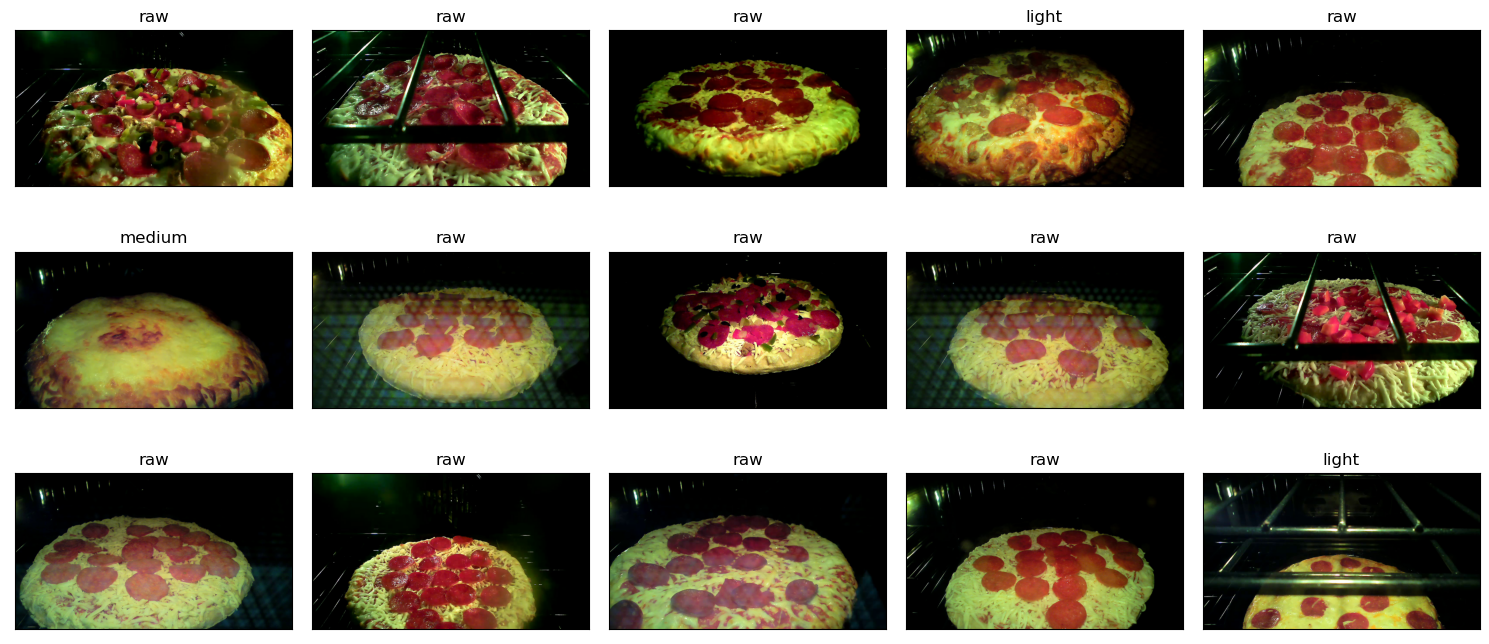

In [8]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

## Training and Testing Data

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_df.head(5)

,Filepath,Label
3376,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
1114,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
1332,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
1812,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw
7714,/kaggle/input/pizza-doneness-imgs/Pizza_Donene...,raw


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7200 validated image filenames belonging to 4 classes.
Found 1800 validated image filenames belonging to 4 classes.
Found 1000 validated image filenames belonging to 4 classes.


## Creating the testing model

In [13]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(4, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [14]:
K.clear_session()
metrics = [
    'accuracy',
    'AUC'
]

model = create_model((224, 224, 3))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)
model.save('models/checkpoint/EfficientNetB0.h5')



27018416/27018416 [==============================] - 0s 0us/step


In [15]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
225/225 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8583 - auc: 0.9492
Epoch 1: val_loss improved from inf to 2.52987, saving model to models/EfficientNetB1/model_224.h5
225/225 [==============================] - 202s 804ms/step - loss: 0.3536 - accuracy: 0.8583 - auc: 0.9492 - val_loss: 2.5299 - val_accuracy: 0.0511 - val_auc: 0.2139 - lr: 0.0010
Epoch 2/15
225/225 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9167 - auc: 0.9676
Epoch 2: val_loss improved from 2.52987 to 1.89982, saving model to models/EfficientNetB1/model_224.h5
225/225 [==============================] - 151s 672ms/step - loss: 0.2213 - accuracy: 0.9167 - auc: 0.9676 - val_loss: 1.8998 - val_accuracy: 0.1589 - val_auc: 0.2224 - lr: 0.0010
Epoch 3/15
225/225 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9396 - auc: 0.9718
Epoch 3: val_loss did not improve from 1.89982
225/225 [==============================] - 151s 669ms/step - 

## Accuracy Graph of our Model

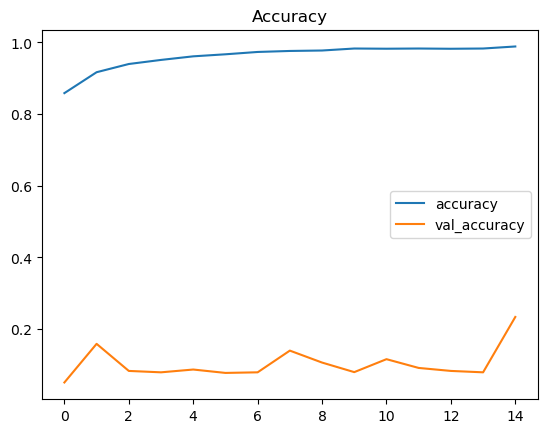

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 2.89488
Test Accuracy: 28.00%


In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

32/32 [==============================] - 17s 458ms/step
The first 5 predictions: ['medium', 'raw', 'medium', 'raw', 'medium']


In [20]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        dark       0.00      0.00      0.00        23
       light       0.35      0.12      0.18       129
      medium       0.11      1.00      0.20        84
         raw       0.99      0.24      0.38       764

    accuracy                           0.28      1000
   macro avg       0.36      0.34      0.19      1000
weighted avg       0.81      0.28      0.33      1000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


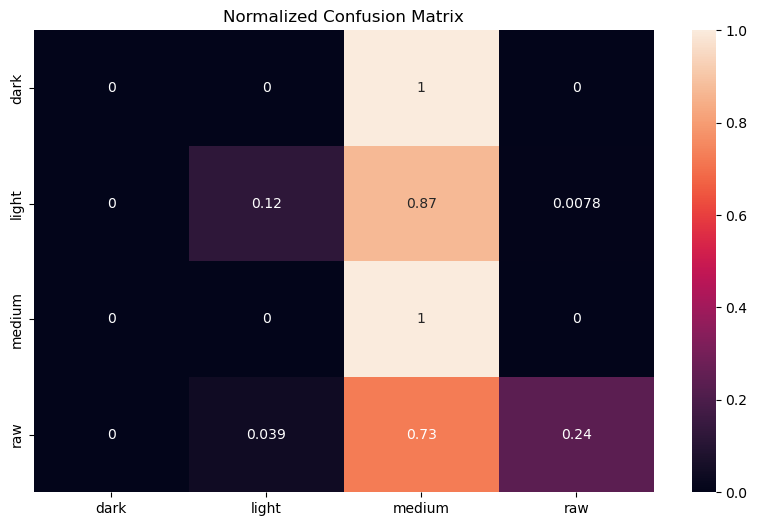

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## Testing with the test data

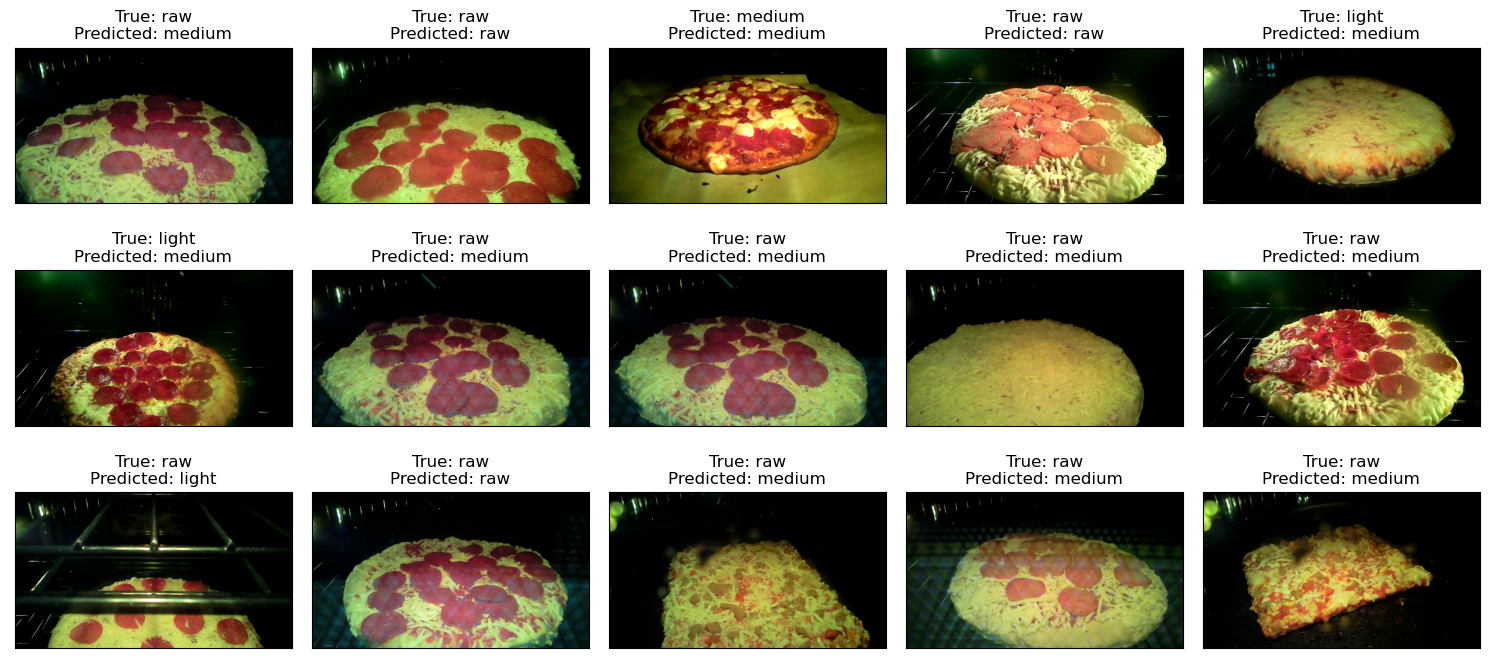

In [22]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()